In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s]


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
model = SimpleCNN().to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
def train(model, loader, optimizer, criterion, epoch_count):
    model.train()
    for epoch in range(epoch_count):
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(loader)
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epoch_count} Loss: {avg_loss:.4f} Test Accuracy: {acc:.2f}%")


In [ ]:
train(model, train_loader, optimizer, criterion, epoch_count=10)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
final_acc = 100 * correct / total
print("Final Test Accuracy:", final_acc)


Epoch 1/10 Loss: 1.7629 Test Accuracy: 48.67%
Epoch 2/10 Loss: 1.2733 Test Accuracy: 56.55%
Epoch 3/10 Loss: 1.0732 Test Accuracy: 62.32%
Epoch 4/10 Loss: 0.9215 Test Accuracy: 67.69%
Epoch 5/10 Loss: 0.8085 Test Accuracy: 68.32%
Epoch 6/10 Loss: 0.7118 Test Accuracy: 71.18%
Epoch 7/10 Loss: 0.6066 Test Accuracy: 70.01%
Epoch 8/10 Loss: 0.5254 Test Accuracy: 72.02%
Epoch 9/10 Loss: 0.4326 Test Accuracy: 72.83%
Epoch 10/10 Loss: 0.3487 Test Accuracy: 72.09%
Final Test Accuracy: 72.09


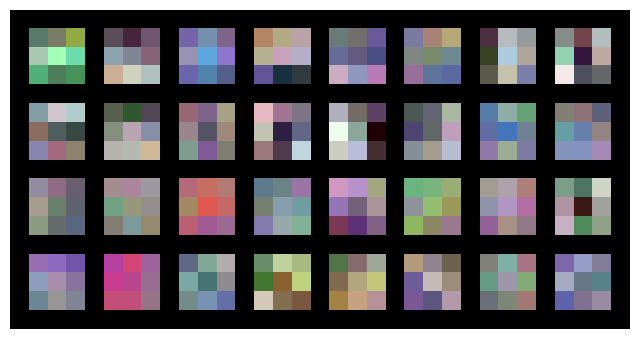

In [ ]:
weights = model.conv1.weight.data.clone().cpu()
min_w = weights.min()
max_w = weights.max()
weights = (weights - min_w) / (max_w - min_w)
grid = make_grid(weights, nrow=8, padding=1)
npimg = grid.numpy()
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
